In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve

import pickle
import joblib

In [3]:
data = pd.read_csv('archive/treino.csv')

In [96]:
test = pd.read_csv('archive/teste.csv')

In [5]:
data.head()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
data.isna().sum()

inadimplente                                 0
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           21763
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     2878
dtype: int64

In [85]:
test.isna().sum()

util_linhas_inseguras                       0
idade                                       0
vezes_passou_de_30_59_dias                  0
razao_debito                                0
salario_mensal                           7968
numero_linhas_crdto_aberto                  0
numero_vezes_passou_90_dias                 0
numero_emprestimos_imobiliarios             0
numero_de_vezes_que_passou_60_89_dias       0
numero_de_dependentes                    1046
dtype: int64

In [7]:
data = data.dropna(axis=0)

In [97]:
test = test.dropna(axis=0)

### Analisando outliers na coluna util_linhas_inseguras

In [8]:
data[data['util_linhas_inseguras'] <= 1].count()

inadimplente                             86183
util_linhas_inseguras                    86183
idade                                    86183
vezes_passou_de_30_59_dias               86183
razao_debito                             86183
salario_mensal                           86183
numero_linhas_crdto_aberto               86183
numero_vezes_passou_90_dias              86183
numero_emprestimos_imobiliarios          86183
numero_de_vezes_que_passou_60_89_dias    86183
numero_de_dependentes                    86183
dtype: int64

In [9]:
data['util_linhas_inseguras'].mean()

5.855375649590165

In [10]:
data.shape

(88237, 11)

### Analisando outliers na coluna razao_debito

In [11]:
data['razao_debito'].median()

0.296660118

In [12]:
data[data['razao_debito'] <= 1].count()

inadimplente                             82893
util_linhas_inseguras                    82893
idade                                    82893
vezes_passou_de_30_59_dias               82893
razao_debito                             82893
salario_mensal                           82893
numero_linhas_crdto_aberto               82893
numero_vezes_passou_90_dias              82893
numero_emprestimos_imobiliarios          82893
numero_de_vezes_que_passou_60_89_dias    82893
numero_de_dependentes                    82893
dtype: int64

### Retirando os outliers dos dados

In [13]:
data = data[(data['salario_mensal'] <= 15000) & (data['util_linhas_inseguras'] <= 1) & (data['razao_debito'] <= 1)]

In [14]:
data.columns

Index(['inadimplente', 'util_linhas_inseguras', 'idade',
       'vezes_passou_de_30_59_dias', 'razao_debito', 'salario_mensal',
       'numero_linhas_crdto_aberto', 'numero_vezes_passou_90_dias',
       'numero_emprestimos_imobiliarios',
       'numero_de_vezes_que_passou_60_89_dias', 'numero_de_dependentes'],
      dtype='object')

In [15]:
X = data.drop('inadimplente', axis=1)
y = data.iloc[:, 0:1]

## Fazendo Balanceamento das classes

<AxesSubplot:xlabel='inadimplente', ylabel='Count'>

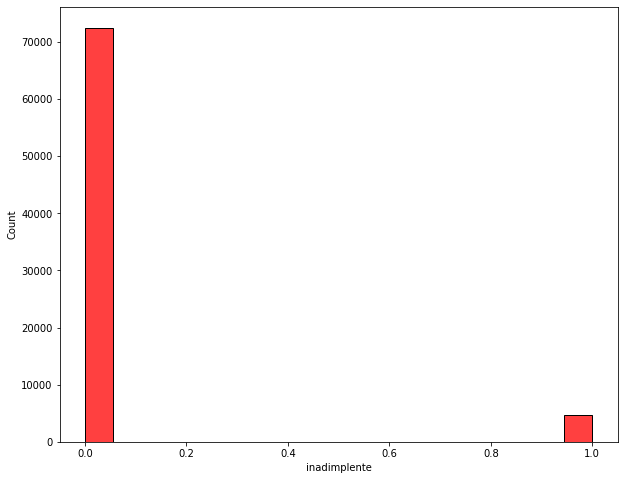

In [16]:
plt.figure(figsize=(10, 8))
sns.histplot(x='inadimplente', data=y, color='RED')

In [17]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

<AxesSubplot:xlabel='inadimplente', ylabel='Count'>

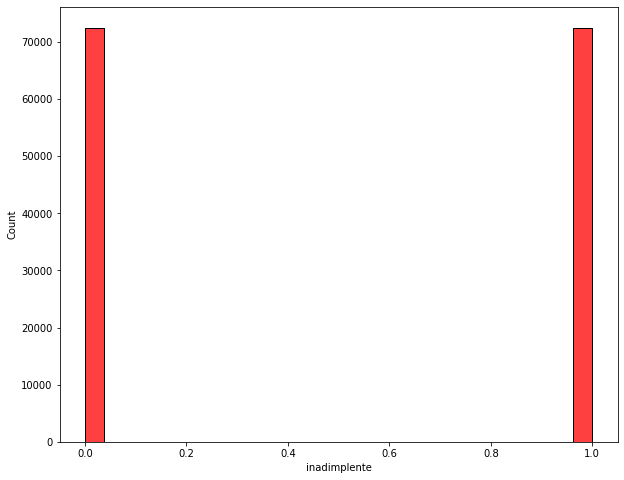

In [18]:
plt.figure(figsize=(10, 8))
sns.histplot(x='inadimplente', data=y_resampled, color='RED')


## Reparticionando o tamanho dos dados

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

# LGBM

In [110]:
gbm = lgb.LGBMClassifier(n_jobs=-1, random_state=42, max_depth=7, learning_rate=0.6).fit(X_train, y_train)

/home/maksonvinicio/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [111]:
gbm.score(X_test, y_test)

0.8897994095411528

In [54]:
y_pred_gbm = gbm.predict(X_test)

In [50]:
from sklearn.metrics import log_loss

In [53]:
for col in X_resampled.columns:
    p = gbm.predict_proba(X_test)
    logLoss = log_loss(y_test, p)
    print(f"Feature {col} : Log loss {logLoss}\n")

Feature util_linhas_inseguras : Log loss 0.25163393457218386

Feature idade : Log loss 0.25163393457218386

Feature vezes_passou_de_30_59_dias : Log loss 0.25163393457218386

Feature razao_debito : Log loss 0.25163393457218386

Feature salario_mensal : Log loss 0.25163393457218386

Feature numero_linhas_crdto_aberto : Log loss 0.25163393457218386

Feature numero_vezes_passou_90_dias : Log loss 0.25163393457218386

Feature numero_emprestimos_imobiliarios : Log loss 0.25163393457218386

Feature numero_de_vezes_que_passou_60_89_dias : Log loss 0.25163393457218386

Feature numero_de_dependentes : Log loss 0.25163393457218386



## Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
clf = DecisionTreeClassifier(min_samples_leaf=2, random_state=42).fit(X_train, y_train)

In [22]:
clf.score(X_test, y_test)

0.8780454156664735

In [23]:
y_pred = clf.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred)

0.8780454156664735

# Cross validation

In [55]:
all_scores = cross_val_score(gbm, X, y, cv=5, scoring='accuracy', n_jobs=-1)

In [56]:
print(all_scores.mean())

0.9312613860643898


In [59]:
features_importance = zip(clf.feature_importances_, X_resampled)
for importance, feature in sorted(features_importance, reverse=True):
    print("%s: %f%%" % (feature, importance*100))

util_linhas_inseguras: 32.212486%
numero_de_dependentes: 31.005821%
salario_mensal: 11.154597%
razao_debito: 7.282582%
idade: 6.331161%
numero_linhas_crdto_aberto: 3.956059%
numero_vezes_passou_90_dias: 3.283299%
vezes_passou_de_30_59_dias: 2.117720%
numero_emprestimos_imobiliarios: 1.967992%
numero_de_vezes_que_passou_60_89_dias: 0.688283%


# Avaliando o modelo

In [60]:
print(classification_report(y_test, y_pred_gbm))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89     18101
           1       0.91      0.87      0.89     18142

    accuracy                           0.89     36243
   macro avg       0.89      0.89      0.89     36243
weighted avg       0.89      0.89      0.89     36243



<AxesSubplot:>

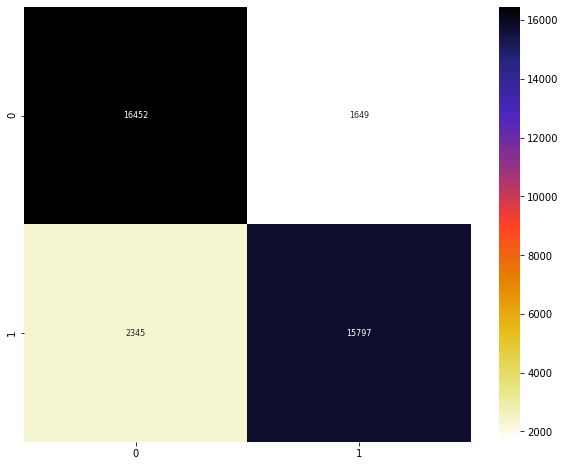

In [61]:
cm = confusion_matrix(y_test, y_pred_gbm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='CMRmap_r', fmt='.0f', annot_kws={'size': 8})

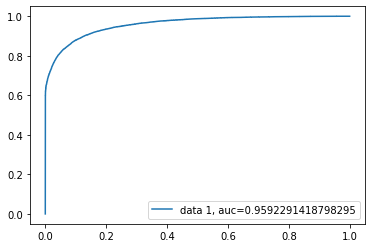

In [62]:
y_probas = gbm.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test,  y_probas)
auc = roc_auc_score(y_test, y_probas)

plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [63]:
def plot_pre_curve(y_test, probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    plt.title("precision recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()

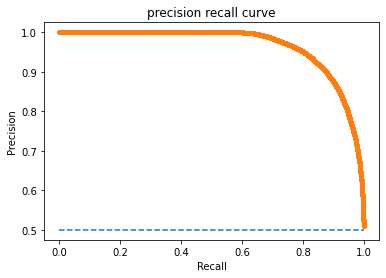

In [64]:
plot_pre_curve(y_test, y_probas)

In [67]:
with open('model_gbm.pkl', 'wb') as file:
    pickle.dump(gbm, file)

## Avaliando o modelo com dados reais

In [99]:
real_pred = gbm.predict(test)

In [107]:
real_pred

array([0, 1, 0, ..., 0, 0, 1])